In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import collections
import functools
import abc
import random

import numpy as np
import jax
import jax.numpy as jnp
import jax.experimental.optimizers
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq

import bvbq
import bvbq.gp

In [3]:
bvbq.gp

<module 'bvbq.gp' from '../bvbq/gp.py'>

In [4]:
ndim = 2
def exponential_quartic(x):
    x1,x2 = x[...,0],x[...,1]
    res = -0.1*x1**4 -0.5*(2*x2-x1**2)**2
#     return -0.5*((x1+1)**2 + (x2 - 1)**2)
    return res

In [5]:
class JaxOptWrapper(object):
    def __init__(self,optimizer,*args,**kwargs):
        self.opt_init,self.opt_update,self.get_params = \
            optimizer(*args,**kwargs)
        self.opt_state = None
        
    def init(self,params,func_and_grad):
        self.i = 0
        self.opt_state = self.opt_init(params)
        self.func_and_grad = func_and_grad
        
    def step(self,*fargs,**fkwargs):
        value, grads = self.func_and_grad(self.get_params(self.opt_state),*fargs,**fkwargs)
        self.opt_state = self.opt_update(i,grads,self.opt_state)
        self.i += 1
        return value,grads
    
    @property
    def params(self):
        return self.get_params(self.opt_state)
    
def function(params):
    x = params['x']
    return jnp.sum(x**2)
#     return -exponential_quartic(x)

learning_rate = 1e-1
optwrapper = JaxOptWrapper(jax.experimental.optimizers.adam,learning_rate)
optwrapper.init({'x':jnp.ones(2)},jax.value_and_grad(function))
for i in range(50):
    value,_ = optwrapper.step()
#     print(value)
print(optwrapper.params)

W0802 19:07:09.685406 140338464823104 xla_bridge.py:137] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


{'x': DeviceArray([-0.00481431, -0.00481431], dtype=float32)}


If tensor has more than 2 dimensions, only diagonal of covariance is returned


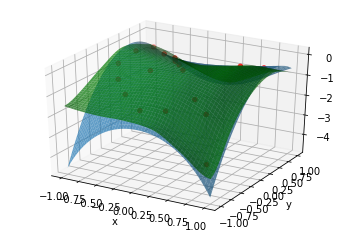

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
x = np.linspace(-1,1)
y = np.linspace(-1,1)
X,Y = np.meshgrid(x,y)
Z = exponential_quartic(np.stack([X,Y],axis=-1))
ax.plot_surface(X,Y,Z,alpha=0.7)

xys = (2*(sobol_seq.i4_sobol_generate(2,20)-0.5)) #[-1,1] cube
zs = exponential_quartic(xys)
ax.scatter(xys[:,0],xys[:,1],zs,color='red')
ax.set_xlabel('x');
ax.set_ylabel('y');

gp = bvbq.gp.SimpleGP(2,kind='smatern32',noise=0)
gp.set_data(xys,zs,empirical_params=True)
gp.optimize_params()
Zreg = gp.predict(np.stack([X,Y],axis=-1))[0]
ax.plot_surface(X,Y,Zreg,alpha=0.7,color='green')

In [7]:
def inds_mean(x,inds,indrange):
    def ind_mean(i):
        return jnp.nan_to_num(jnp.mean(x[inds==i]))
    return jnp.stack([ind_mean(i) for i in indrange])

class ProbabilityDistribution(abc.ABC):
    def __init__(self,seed):
        self.seed = seed
        self.key = jax.random.PRNGKey(seed)
        self.ismixture = False
        
    def split_key(self):
        key,subkey = jax.random.split(self.key)
        self.key = key
        return subkey
    
    @abc.abstractmethod
    def logprob(self,x):
        pass
    
    @abc.abstractmethod
    def sample(self,n):
        pass

    @property
    @abc.abstractmethod
    def params(self):
        pass
    
    def monte_carlo_entropy(self,n):
        return -jnp.mean(self.logprob(self.sample(n)))

    
class DiagonalNormalDistribution(ProbabilityDistribution):
    def __init__(self,mean,var,seed=random.randint(1,1000)):
        super().__init__(seed)
        self.ndim = mean.shape[0]
        self.mean = mean
        self.var = var
        assert(len(self.var) == self.ndim)
        assert(len(self.mean) == self.ndim)
        self.std = jnp.sqrt(self.var)
    
    def logprob(self,x):
        res = self._logprob(x,self.mean,self.var,self.ndim)
        return res
    
    @functools.partial(jax.jit,static_argnums=(0,))
    def _logprob(self,x,mean,std,ndim):
        res = -0.5*jnp.sum(((x-mean)/std)**2,axis=-1) \
              -jnp.sum(jnp.log(std)) - ndim/2*jnp.log(2*jnp.pi)
        return res
    
    def sample(self,n):
        res = self._sample(n,self.mean,self.std)
        return res
    
#     @functools.partial(jax.jit,static_argnums=(0,1))
    def _sample(self,n,mean,std):
        ndim = mean.shape[0]
        subkey = self.split_key()
        z = jax.random.normal(subkey,shape=(n,ndim))
        res = mean + std*z
        return res
    
    def make_mixture(self):
        means = jnp.expand_dims(self.mean,0)
        variances = jnp.expand_dims(self.var,0)
        weights = jnp.ones(1)
        return MixtureDiagonalNormalDistribution(means,variances,weights)
    
    @property
    def params(self):
        return self.mean,self.var

    def analytical_entropy(self):
        return 0.5*jnp.sum(jnp.log(2*jnp.pi*jnp.e*self.var))
    
class MixtureDiagonalNormalDistribution(ProbabilityDistribution):
    def __init__(self,means,variances,weights,seed=random.randint(1,1000)):
        super().__init__(seed)
        self.nmixtures = weights.shape[0]
        self.ndim = means.shape[1]
        self.means = means
        self.variances = variances
        self.weights = weights
        assert(self.variances.shape[1] == self.ndim)
        assert(self.means.shape[0] == self.nmixtures)
        assert(self.variances.shape[0] == self.nmixtures)
        self.stds = jnp.sqrt(variances)
        self.ismixture = True
        
    def logprob(self,x):
        res = self._logprob(x,self.means,self.stds,self.weights)
        return res
    
    @functools.partial(jax.jit,static_argnums=(0,))
    def _logprob(self,x,means,stds,weights):
        ndim = means.shape[1]
        x = jnp.expand_dims(x,-2) #(n,1,d)
        yi1 = -0.5*jnp.sum(((x-means)/stds)**2,axis=-1) #(n,m)
        yi2 = -jnp.sum(jnp.log(stds),axis=-1) #(m,)
        yi3 = -ndim/2*jnp.log(2*jnp.pi) #(,)
        yi = yi1 + yi2 + yi3 #(n,m)
        ymax = jnp.max(yi,axis=-1,keepdims=True) #(n,1)
        sumexp = jnp.sum(weights*jnp.exp(yi-ymax),axis=-1)
        res = jnp.squeeze(ymax,axis=-1) + jnp.log(sumexp) #(n,)
        return res
        
    def sample(self,n):
        res = self._sample(n,self.means,self.stds,self.weights)
        return res
    
#     @functools.partial(jax.jit,static_argnums=(0,1))
    def _sample(self,n,means,stds,weights):
        subkey = self.split_key()
        nmixtures,ndim = means.shape
        catinds = jax.random.choice(subkey,nmixtures,shape=(n,),p=weights)
        z = jax.random.normal(subkey,shape=(n,ndim))
        res = means[catinds,:] + stds[catinds,:]*z
        return res
    
    @property
    def params(self):
        return self.means,self.variances,self.weights
    
    def add_component(self,mean,var,weight,return_new=False):
        weights = jnp.append((1-weight)*self.weights,weight)
        means = jnp.vstack([self.means,mean])
        variances = jnp.vstack([self.variances,var])
        if return_new:
            return MixtureDiagonalNormalDistribution(means,variances,weights)
        else:
            self.means = means
            self.variances = variances
            self.weights = weights
            self.stds = jnp.sqrt(variances)
            self.nmixtures += 1

In [ ]:
x = np.random.rand(5,2)

distrib = DiagonalNormalDistribution(-jnp.ones(2),0.1*jnp.ones(2))
print(distrib.sample(100).mean(axis=0))
print(distrib.logprob(x))
print(distrib.sample(101).mean(axis=0))

[-1.0152851 -0.9619214]
[-300.76132 -291.00766 -283.68445 -281.88437 -232.88795]


In [ ]:
distrib.sample(1000)

In [ ]:
mixdistrib = distrib.make_mixture()
mixdistrib.add_component(jnp.ones(2),0.1*jnp.ones(2),0.1)
mixdistrib.add_component(2*jnp.ones(2),0.1*jnp.ones(2),0.1)
print(mixdistrib.logprob(x))
print(mixdistrib.sample(100).mean())
print(mixdistrib.sample(101).mean())

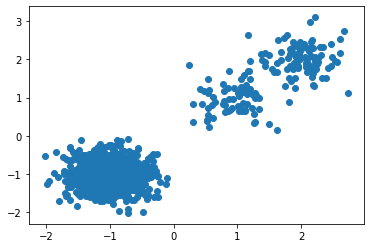

In [11]:
x = mixdistrib.sample(1000)
plt.scatter(x[:,0],x[:,1])

In [12]:
@jax.jit
def logbound(logx,logdelta):
    clipx = jnp.clip(logx,logdelta,None)
    boundx = clipx + jnp.log(jnp.exp(logx-clipx) + \
                             jnp.exp(logdelta-clipx))
    return boundx

In [13]:
def monte_carlo_bayesian_quadrature(gp,distrib,nsamples):
    samples1 = distrib.sample(nsamples)
    samples2 = distrib.sample(nsamples)
    samples3 = distrib.sample(nsamples)
    z = gp.kernel_function(gp.X,samples1).mean(axis=-1,keepdims=True) #(m,1)
    gamma = gp.kernel_function(samples2,samples3,diagonal=True).mean()
    y_ = jax.scipy.linalg.solve_triangular(gp.upper_chol_matrix,
                                           gp.y-gp.mean,
                                           trans='T') #(m,1)
    z_ = jax.scipy.linalg.solve_triangular(gp.upper_chol_matrix,
                                           z,
                                           trans='T') #(m,1)
    mean = gp.mean + z_.transpose()@y_
    var = gamma - z_.transpose()@z_
    return mean,var

def false_monte_carlo_bayesian_quadrature(gp,distrib,nsamples):
    samples = distrib.sample(nsamples)
    mean = jnp.mean(gp.predict(distrib.sample(nsamples),return_cov=False))
    return mean

def logprob_quadrature(logprob,distrib,nsamples):
    return jnp.mean(logprob(distrib.sample(nsamples)))

def elbo(logprob,distrib,nsamples):
    term1 = distrib.monte_carlo_entropy(nsamples)
    term2 = logprob_quadrature(logprob,distrib,nsamples)
    return term1 + term2

def boosted_elbo(logprob,distrib,newcomp,newweight,nsamples):
    samples_distrib = distrib.sample(nsamples)
    samples_newcomp = newcomp.sample(nsamples)
    joint_distrib = distrib.add_component(*newcomp.params,newweight,return_new=True)
    logprob_mean_1 = logprob(samples_distrib).mean()
    partial_entropy_1 = -joint_distrib.logprob(samples_distrib).mean()
    logprob_mean_2 = logprob(samples_newcomp).mean()
    partial_entropy_2 = -joint_distrib.logprob(samples_newcomp).mean()
    res = (1-newweight)*(logprob_mean_1 + partial_entropy_1) + \
          newweight*(logprob_mean_2 + partial_entropy_2)
    return res

def vbq_elbo(gp,distrib,nsamples):
    term1 = distrib.monte_carlo_entropy(nsamples)
#     term2,_ = monte_carlo_bayesian_quadrature(gp,distrib,nsamples)
#     term2 = term2[0][0]
    term2 = false_monte_carlo_bayesian_quadrature(gp,distrib,nsamples)
    return term1 + term2

def relbo(logprob,distrib,newcomp,nsamples,reg=1e-2,logdelta=-10):
    global logprobmean
    samples = newcomp.sample(nsamples)
#     entropy = -newcomp.logprob(samples).mean() #-E[log(q)]
    entropy = newcomp.analytical_entropy()
#     logprobmean = logbound(logprob(samples),logdelta).mean()
    logprobmean = logprob(samples).mean()
    negdistribmean = -logbound(distrib.logprob(samples),logdelta).mean()
#     print(logprobmean.primal,
#           negdistribmean.primal,
#           (reg*entropy).primal)
    res = logprobmean + negdistribmean + reg*entropy
#     res = logprobmean + negdistribmean + reg*entropy
    return res

In [37]:
def logprob_t(x,nu):
    normalizer = jax.scipy.special.gammaln((nu+1)/2) \
                 -jax.scipy.special.gammaln(nu/2) \
                 -0.5*jnp.log(jnp.pi*nu)
    main_term = -(nu+1)/2*jnp.log(1+x**2/nu)
    return main_term + normalizer

def objective_function_relbo_2(params,mixdistrib):
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    newcomp = DiagonalNormalDistribution(mean,var)
    logprob = functools.partial(logprob_t,nu=1)
    res = -relbo(logprob,mixdistrib,newcomp,1000,reg=1e0,logdelta=-5)
    return res

def objective_function_gradboost_2(weight,distrib,mixdistrib):
    logprob = functools.partial(logprob_t,nu=1000)
    res = -boosted_elbo(logprob,mixdistrib,distrib,weight,1000)
    return res

params = {'mean':jnp.zeros(1),'rawvar':0.1*jnp.zeros(1)}
distrib = DiagonalNormalDistribution(5*jnp.ones(1),jnp.ones(1))
mixdistrib = distrib.make_mixture()
func_and_grad_relbo = jax.value_and_grad(objective_function_relbo_2,argnums=0)
func_and_grad_relbo(params,mixdistrib)
print(func_and_grad_relbo(params,mixdistrib))
weight = 0.5
func_and_grad_gradboost = jax.value_and_grad(objective_function_gradboost_2)
print(func_and_grad_gradboost(0.5,distrib,mixdistrib))

(DeviceArray(-4.644832, dtype=float32), {'mean': DeviceArray([-0.00993357], dtype=float32), 'rawvar': DeviceArray([-0.12087336], dtype=float32)})
(DeviceArray(12.02814, dtype=float32), DeviceArray(-0.13554192, dtype=float32))


In [ ]:
alpha_boost = 1e0
maxiter_boost = 100
alpha_relbo = 3*1e-1
maxiter_relbo = 100
maxiter = 100
optwrapper = JaxOptWrapper(jax.experimental.optimizers.sgd,alpha_relbo)
for k in range(maxiter):
    params = {'mean':jax.random.normal(mixdistrib.split_key(),(1,)),
              'rawvar':3*jax.random.normal(mixdistrib.split_key(),(1,))}
    optwrapper.init(params,func_and_grad_relbo)
    for i in range(maxiter_relbo):
        value,grads = optwrapper.step(mixdistrib)
        params = optwrapper.params
#         print(value,params['mean'],jax.nn.softplus(params['rawvar']))
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    distrib = DiagonalNormalDistribution(mean,var)
    weight = 0.01
    print('--')
    print(mean,var)
    for i in range(maxiter_boost):
        res,gradweight = func_and_grad_gradboost(weight,distrib,mixdistrib)
        weight -= alpha_boost*(i/10+1)**(-0.55)*gradweight
        weight = jnp.clip(weight,1e-4,1-1e-4)
        if abs(gradweight) < 1e-2:
            break
#         print(weight,res,gradweight)
    mixdistrib.add_component(mean,var,weight)
    print(k,mean,var,weight)
    print('--')

--
[-0.06994728] [1.2651044]
0 [-0.06994728] [1.2651044] 0.9999
--
--
[3.4794006] [4.879013]
1 [3.4794006] [4.879013] 1e-04
--
--
[4.307823] [3.0219526]
2 [4.307823] [3.0219526] 1e-04
--
--
[-2.9195395] [6.163182]
3 [-2.9195395] [6.163182] 1e-04
--
--
[-3.8174124] [5.670409]
4 [-3.8174124] [5.670409] 1e-04
--
--
[3.0653992] [4.182945]
5 [3.0653992] [4.182945] 1e-04
--
--
[3.3673673] [4.3600907]
6 [3.3673673] [4.3600907] 1e-04
--
--
[-3.8297353] [5.892457]
7 [-3.8297353] [5.892457] 1e-04
--
--
[-3.9883769] [5.3611374]
8 [-3.9883769] [5.3611374] 1e-04
--
--
[3.3124573] [6.8439174]
9 [3.3124573] [6.8439174] 1e-04
--
--
[-4.1867347] [3.6914783]
10 [-4.1867347] [3.6914783] 1e-04
--
--
[-3.48851] [6.2984805]
11 [-3.48851] [6.2984805] 1e-04
--
--
[-1.6977558] [7.7924204]
12 [-1.6977558] [7.7924204] 1e-04
--
--
[1.5979359] [6.4642777]
13 [1.5979359] [6.4642777] 1e-04
--
--
[3.6075623] [4.9569926]
14 [3.6075623] [4.9569926] 1e-04
--
--
[4.297465] [3.5134735]
15 [4.297465] [3.5134735] 1e-04
--
-

In [26]:
print(logprobmean.primal)

-2.647719


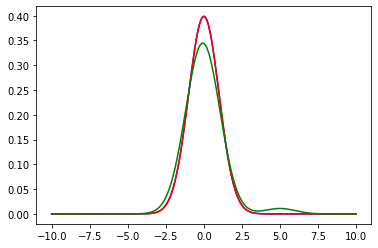

In [27]:
x = np.linspace(-10,10,201)
y = logprob_t(x,1000)
y2 = -0.5*x**2 - 0.5*np.log(2*np.pi)
yvi = mixdistrib.logprob(x.reshape(-1,1)).flatten()
plt.plot(x,np.exp(y),'b')
plt.plot(x,np.exp(y2),'r')
plt.plot(x,np.exp(yvi),'g')

In [62]:
mixdistrib.weights.sum()

DeviceArray(1., dtype=float32)

In [63]:
mixdistrib.add_component(np.zeros(1),np.ones(1),0.5)

In [28]:
def exponential_quartic(x):
    x1,x2 = x[...,0],x[...,1]
    res = -0.1*x1**4 -0.5*(2*x2-x1**2)**2
#     return -0.5*((x1+1)**2 + (x2 - 1)**2)
    return res

def objective_function_relbo_2(params,mixdistrib):
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    newcomp = DiagonalNormalDistribution(mean,var)
    logprob = functools.partial(logprob_t,nu=1)
    res = -relbo(logprob,mixdistrib,newcomp,1000,reg=1e0,logdelta=-5)
    return res

def objective_function_gradboost_2(weight,distrib,mixdistrib):
#     logprob = functools.partial(logprob_t,nu=1000)
    logprob = exponential_quartic
    res = -boosted_elbo(logprob,mixdistrib,distrib,weight,1000)
    return res

params = {'mean':jnp.zeros(2),'rawvar':0.1*jnp.zeros(2)}
distrib = DiagonalNormalDistribution(jnp.zeros(2),jnp.ones(2))
mixdistrib = distrib.make_mixture()
func_and_grad_relbo = jax.value_and_grad(objective_function_relbo_2,argnums=0)
func_and_grad_relbo(params,mixdistrib)
print(func_and_grad_relbo(params,mixdistrib))
weight = 0.5
func_and_grad_gradboost = jax.value_and_grad(objective_function_gradboost_2)
print(func_and_grad_gradboost(0.5,distrib,mixdistrib))

(DeviceArray(-3.3298476, dtype=float32), {'mean': DeviceArray([ 0.02696834, -0.00192559], dtype=float32), 'rawvar': DeviceArray([-0.45977354, -0.46495342], dtype=float32)})
(DeviceArray(0.7937801, dtype=float32), DeviceArray(-0.3567009, dtype=float32))


In [31]:
alpha_boost = 1e0
maxiter_boost = 100
alpha_relbo = 3*1e-1
maxiter_relbo = 100
maxiter = 100
optwrapper = JaxOptWrapper(jax.experimental.optimizers.sgd,alpha_relbo)
for k in range(maxiter):
    params = {'mean':jax.random.normal(mixdistrib.split_key(),(2,)),
              'rawvar':3*jax.random.normal(mixdistrib.split_key(),(2,))}
    optwrapper.init(params,func_and_grad_relbo)
    for i in range(maxiter_relbo):
        value,grads = optwrapper.step(mixdistrib)
        params = optwrapper.params
#         print(value,params['mean'],jax.nn.softplus(params['rawvar']))
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
#     mean,var = jnp.zeros(1),jnp.ones(1)
    distrib = DiagonalNormalDistribution(mean,var)
    weight = 0.01
    print('--')
    print(mean,var)
    for i in range(maxiter_boost):
        res,gradweight = func_and_grad_gradboost(weight,distrib,mixdistrib)
        weight -= alpha_boost*(i/10+1)**(-0.55)*gradweight
        weight = jnp.clip(weight,1e-4,1-1e-4)
        if abs(gradweight) < 1e-2:
            break
        print(weight,res,gradweight)
    mixdistrib.add_component(mean,var,weight)
    print(k,mean,var,weight)
    print('--')

--
[2.0176463  0.15602534] [4.0058856 4.8287177]
0.9999 42.3818 -42.779213
0.9999 0.7324837 -41.257545
0.9999 1.0471963 -36.1346
0.9999 0.8473959 -34.7189
0.9999 0.82524025 -38.05284
0.9999 1.2454228 -37.8466
0.9999 0.9121246 -35.630173
0.9999 0.92420745 -42.466038
0.9999 0.85597146 -34.79562
0.9999 1.192225 -39.333572
0.9999 1.5650022 -42.957005
0.9999 0.76759386 -32.356495
0.9999 0.9269168 -43.630104
0.9999 1.0129968 -45.513023
0.9999 0.5629518 -38.285458
0.9999 1.2774165 -39.248383


KeyboardInterrupt: 